<a href="https://colab.research.google.com/github/Ellen-Gu/jupyter-colab/blob/main/pyspark_speedTest_and_spark_SQL_magic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# To use pyspark it is better to install pyspark and all its extra modules, such as the pyarrow
# pyspark webpage has a very clear installation instructions.
# To run pyspark, java (version>=8, 11, or 17) must be installed, and JAVA_HOME shall be set as env variable
# Google colab use java 11, while in my local running env java 17 can be installed

Below is a modification of PySpark's example that employs the Monte Carlo (MC) method to estimate the value of $\pi$. While it's feasible to execute these operations on the Google Colab computing environment, the outcomes leave something to be desired, especially when considering Spark's reputation for rapid execution. I conducted a speed test on Google Colab (utilizing a free account with 12.7GB RAM) to gauge the potential time savings. The results are as follows and they seems not suggest that spark is very fast, or, more precisly, google colab free account may not powerful enough to make spark's benefit exceeds much of its overhead effect.

* 9.74 s ± 1.49 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
* 9.48 s ± 899 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Then I switch the running environment to my local one. In my local environment, the time zone is set to be UTC+0. Since Java is using port 4040 and 4041, spark has to use 4042.

In [2]:
from pyspark.sql import SparkSession
from numpy import random
import pandas as pd, numpy as np
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/17 18:35:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/17 18:35:55 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/08/17 18:35:55 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [3]:
def sample(p):
    x, y = random.random(), random.random()
    return 1 if x*x + y*y < 1 else 0

# Number of samples
n = 5000000

pi_mc=pd.Series(np.arange(n)).apply(sample).sum()/n*4
print("Pi is roughly %f" % (pi_mc))
%timeit pi=pd.Series(np.arange(n)).apply(sample).sum()/n*4

count = sc.parallelize(range(0, n)).map(sample).reduce(lambda a, b: a + b)
print("Pi is roughly %f" % (4.0 * count / n))
%timeit count = sc.parallelize(range(0, n)).map(sample).reduce(lambda a, b: a + b)


Pi is roughly 3.143255
5.89 s ± 81.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Pi is roughly 3.141766


2.36 s ± 68.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


when using pyspark in the above test on my local environment, the results in the above show that spark's speed is between 2X ~ 3X of general python computing. This is just a mini test, data are small. For large data sets and other file system settings, the speed up of pyspark could reach 10X to 100X and even more as per openAI.

In the test I did see that all 4 cores which allocated to my local docker environment work at 399% (4 threads) at peak time. The general python calculating generally only use 1 thread (at 100% so one thread is used). The overhead of pyspark may drag down some speed. When data is large the effect of overhead is diminishing. Later I may consider to allocate 6 cores to docker, and also compare numba's speed. Numba is another module which can speed up. So how speedy it can be on my local environment is waiting to be tested.

Another intriguing aspect is the use of IPython magic. Spark supports SQL syntax, and there are several IPython extensions, as well as line and cell magics available for use. Databricks also offers its %%sql magic that integrates seamlessly into Jupyter notebooks.

In my local environment, I have both R and Python kernels. The rpy2 package in R introduces the %%R magic, making it incredibly convenient to integrate R and Python. In certain other work environments, the saspy module provides me with the %%SAS magic.

The magics is very convenient when working with jupyter notebook or jupyterlab. I have no interest to make a Spark server or install spark kernel, and do not want to install those magic extensions just for using %%sql instead of spark.sql(). Then can I still enjoy a home made %%sql or %sql magic like the one in databricks? With the vast number of individuals passionately working with Python, the answer is undoubtedly a 'YES'.

In Ipython documentation webpage, https://ipython.readthedocs.io/en/stable/config/custommagics.html, there's a comprehensive list of features. Meanwhile, at https://notebook.community/LucaCanali/Miscellaneous/Pyspark_SQL_Magic_Jupyter/IPython_Pyspark_SQL_Magic , Luca Canali presents a succinct, clear, and easily understandable code snippet to create a line/cell SQL magic. I'm particularly fond of this one because the entire process of creating the magic is transparent and evident to users. It gives me more confidence in its use compared to other SQL magic extensions, even those available in PyPI collections.

The %%sql magic from Luca Canali mirrors the functionality of %%SQL in Databricks. However, since the example code was written in September 2016, parts of it seem incompatible with today's Spark versions. I've made some updates and enhancements to the example to ensure it aligns with the recently installed PySpark (as of August 16, 2023) in my local Docker environment. Now, thanks to Luca Canali, the SQL examples run seamlessly using both %%sql and %sql magics. I'm thrilled that I can now enjoy the convenience of %%sql and %%R magics in my Jupyter setup. It's reminiscent of Databricks, yet even more convenient and customizable under my guidance.

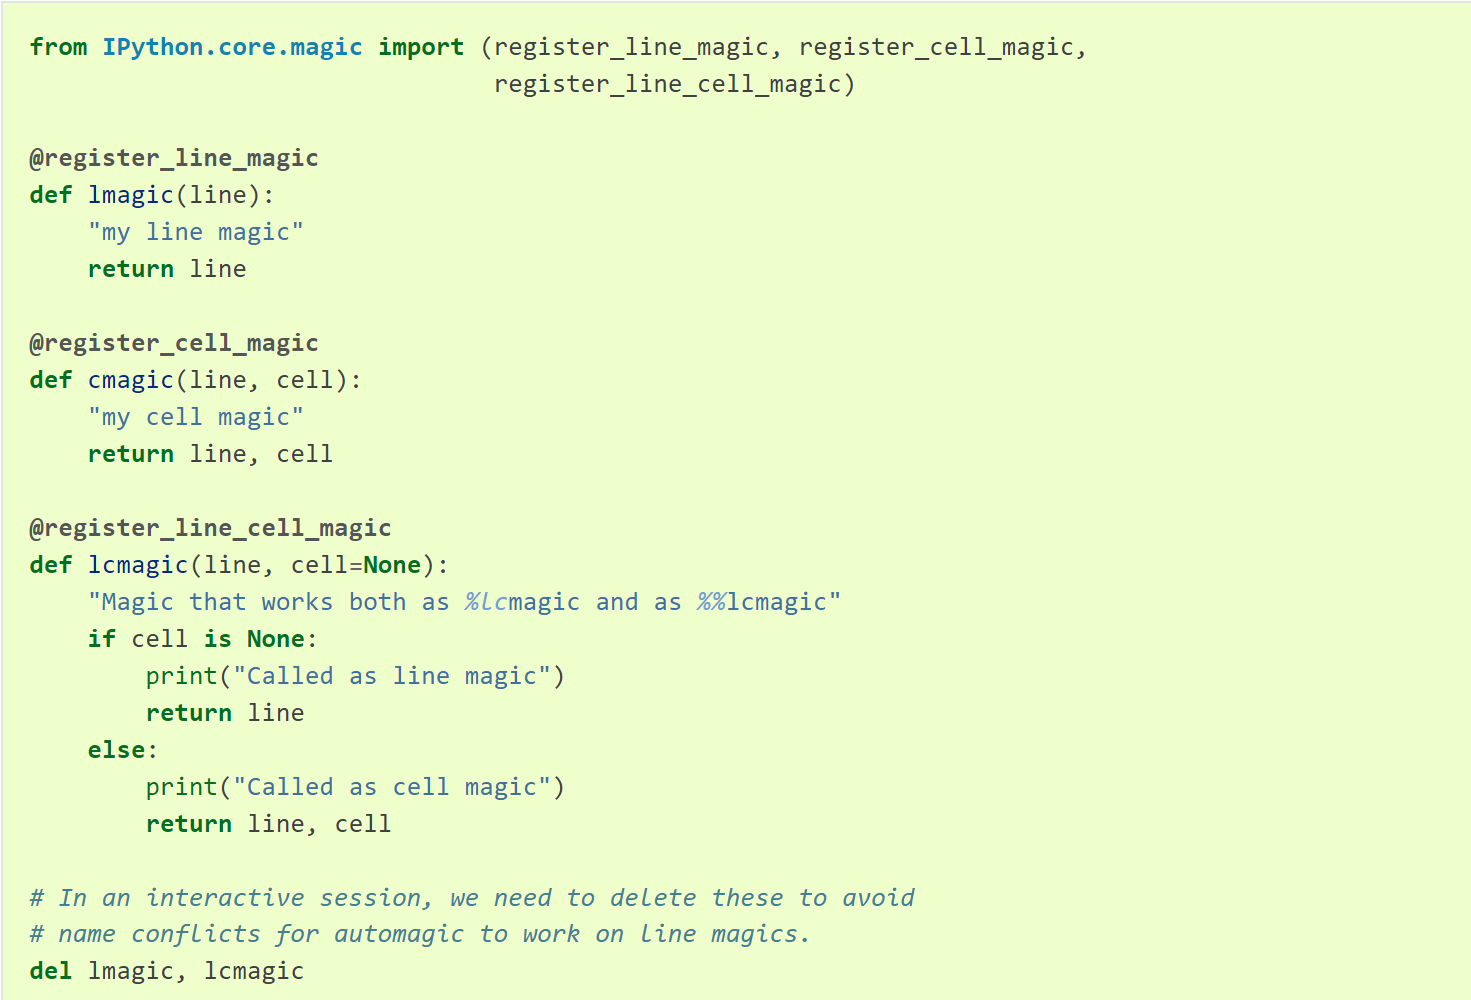

In [5]:
# IPython magic functions to use with Pyspark and Spark SQL
# The following code is intended as examples of shorcuts to simplify the use of SQL in pyspark
# The defined functions are:
#
# %sql <statement>          - return a Spark DataFrame for lazy evaluation of the SQL
# %sql_show <statement>     - run the SQL statement and show max_show_lines (50) lines
# %sql_display <statement>  - run the SQL statement and display the results using a HTML table
#                           - this is implemented passing via Pandas and displays up to max_show_lines (50)
# %sql_explain <statement>  - display the execution plan of the SQL statement
#
# Use: %<magic> for line magic or %%<magic> for cell magic.
#
# Author: Luca.Canali@cern.ch
# September 2016
#

from IPython.core.magic import register_line_cell_magic

# Configuration parameters
max_show_lines = 50         # Limit on the number of lines to show with %sql_show and %sql_display
detailed_explain = True     # Set to False if you want to see only the physical plan when running explain


@register_line_cell_magic
def sql(line, cell=None):
    "Return a Spark DataFrame for lazy evaluation of the sql. Use: %sql or %%sql"
    val = cell if cell is not None else line
    return spark.sql(val)

@register_line_cell_magic
def sql_show(line, cell=None):
    "Execute sql and show the first max_show_lines lines. Use: %sql_show or %%sql_show"
    val = cell if cell is not None else line
    return spark.sql(val).show(max_show_lines)

@register_line_cell_magic
def sql_display(line, cell=None):
    """Execute sql and convert results to Pandas DataFrame for pretty display or further processing.
    Use: %sql_display or %%sql_display"""
    val = cell if cell is not None else line
    return spark.sql(val).limit(max_show_lines).toPandas()

@register_line_cell_magic
def sql_explain(line, cell=None):
    "Display the execution plan of the sql. Use: %sql_explain or %%sql_explain"
    val = cell if cell is not None else line
    return spark.sql(val).explain(detailed_explain)

Now we have all line/cell sql magic defined. Let's happily run spark sql with them!

To begin with PySpark, one must first initialize a Spark session. This concept may remind some of the SAS CAS session, doesn't it? To fully harness the capabilities of Spark, magics, and other features, we're left with two options: find an all-encompassing environment (which can be challenging and expensive) or learn to construct our own.

In [6]:
from pyspark.sql import SparkSession
from numpy import random
import pandas as pd, numpy as np
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

23/08/17 19:48:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/08/17 19:48:28 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


Once set up, we can execute examples within this session. PySpark facilitates a two-way conversion between Spark DataFrames and Pandas DataFrames, enabling easy transitioning between the two. Once all tasks are completed, it's essential to terminate the Spark session. Contrary to the SAS CAS session, typically only one Spark session is permitted per kernel. However, with the right configurations, it's possible to operate multiple sessions concurrently.

In [7]:
# Define test data and register it as tables
# This is a classic example of employee and department relational tables
# Test data will be used in the examples later in this notebook

from pyspark.sql import Row

Employee = Row("id", "name", "email", "manager_id", "dep_id")
df_emp = spark.createDataFrame([
        Employee(1234, 'John', 'john@mail.com', 1236, 10),
        Employee(1235, 'Mike', 'mike@mail.com', 1237, 10),
        Employee(1236, 'Pat', 'pat@mail.com', 1237, 20),
        Employee(1237, 'Claire', 'claire@mail.com', None, 20),
        Employee(1238, 'Jim', 'jim@mail.com', 1236, 30)
        ])
df_emp.createOrReplaceTempView("employee")
#df_emp.registerTempTable("employee")

Department = Row("dep_id", "dep_name")
df_dep = spark.createDataFrame([
        Department(10, 'Engineering'),
        Department(20, 'Head Quarter'),
        Department(30, 'Human resources')
        ])
df_dep.createOrReplaceTempView("department")
#df_dep.registerTempTable("department")

In [10]:
df = %sql select * from employee
df

DataFrame[id: bigint, name: string, email: string, manager_id: bigint, dep_id: bigint]

In [9]:
%%sql_show
select emp.id, emp.name, emp.email, emp.manager_id, dep.dep_name
from employee emp, department dep
where emp.dep_id=dep.dep_id

+----+------+---------------+----------+---------------+
|  id|  name|          email|manager_id|       dep_name|
+----+------+---------------+----------+---------------+
|1234|  John|  john@mail.com|      1236|    Engineering|
|1235|  Mike|  mike@mail.com|      1237|    Engineering|
|1236|   Pat|   pat@mail.com|      1237|   Head Quarter|
|1237|Claire|claire@mail.com|      null|   Head Quarter|
|1238|   Jim|   jim@mail.com|      1236|Human resources|
+----+------+---------------+----------+---------------+



In [11]:
%%sql_display
select emp.id, emp.name, emp.email, emp2.name as manager_name, dep.dep_name
from employee emp
     left outer join employee emp2 on emp2.id=emp.manager_id
     join department dep on emp.dep_id=dep.dep_id

,id,name,email,manager_name,dep_name
0,1235,Mike,mike@mail.com,Claire,Engineering
1,1234,John,john@mail.com,Pat,Engineering
2,1237,Claire,claire@mail.com,None,Head Quarter
3,1236,Pat,pat@mail.com,Claire,Head Quarter
4,1238,Jim,jim@mail.com,Pat,Human resources


In [12]:
spark.sql('''CREATE OR REPLACE TEMPORARY VIEW emp as select * from employee''')

DataFrame[]

In [13]:
%sql_show select * from emp

+----+------+---------------+----------+------+
|  id|  name|          email|manager_id|dep_id|
+----+------+---------------+----------+------+
|1234|  John|  john@mail.com|      1236|    10|
|1235|  Mike|  mike@mail.com|      1237|    10|
|1236|   Pat|   pat@mail.com|      1237|    20|
|1237|Claire|claire@mail.com|      null|    20|
|1238|   Jim|   jim@mail.com|      1236|    30|
+----+------+---------------+----------+------+



In [14]:
psdf = %sql select * from emp
psdf  #spark dataframe

DataFrame[id: bigint, name: string, email: string, manager_id: bigint, dep_id: bigint]

In [15]:
pddf=psdf.toPandas()
pddf  #pandas dataframe

,id,name,email,manager_id,dep_id
0,1234,John,john@mail.com,1236.0,10
1,1235,Mike,mike@mail.com,1237.0,10
2,1236,Pat,pat@mail.com,1237.0,20
3,1237,Claire,claire@mail.com,NaN,20
4,1238,Jim,jim@mail.com,1236.0,30


In [16]:
pddf2 = %sql_display select * from emp
pddf2  #use %sql_display to get spark temp data and then turn to pandas dataframe in one shot, only first 50 rows are fetched

,id,name,email,manager_id,dep_id
0,1234,John,john@mail.com,1236.0,10
1,1235,Mike,mike@mail.com,1237.0,10
2,1236,Pat,pat@mail.com,1237.0,20
3,1237,Claire,claire@mail.com,NaN,20
4,1238,Jim,jim@mail.com,1236.0,30


In [17]:
# Stop the SparkContext
spark.stop()